## What is multilabel classification?

Imagine a paragraph from any article and one want to associate a tag to it for example `Science and Tech`, `crime`
`Economics` etc. 
Now, one article can be assigned multilabels and each label is correct in some sense. We can also weight how each label is correct.

This task of predicting most suitable label fall under multilabel classification task. 

### We are going to use Vowpal Wabbit Library because of it's online learning and high speed functionality

In [1]:
from vowpalwabbit import pyvw
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
import re
import random

We will use `BibTex` data for this specific task which has `159` tags available for each dataset.

In [2]:
def parse_data(file_name):
    features = list()
    labels = list()
    with open(file_name, 'rt') as f:
        f.readline()
        for l in f:
            if bool(re.search("^[0-9]", l)):
                g = re.search("^(([0-9]{1,2},?)+)\s(.*)$", l)
                labels.append([int(i) for i in g.group(1).split(",")])
                features.append(eval("{" + re.sub("\s", ",", g.group(3)) + "}"))
            else:
                l = l.strip()
                labels.append([])
                features.append(eval("{" + re.sub("\s", ",", l) + "}"))
    features_ = pd.DataFrame.from_dict(features).fillna(0).as_matrix()
    df = pd.DataFrame.from_dict(features).fillna(0)
    mlb = MultiLabelBinarizer()
    y = mlb.fit_transform(labels)
    return features_, y, df

X, y, df = parse_data("data/Bibtex/Bibtex_data.txt")

/home/shivansh/anaconda3/envs/dl/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app


In [3]:
df.shape, y.shape

((7394, 1836), (7394, 159))

In this data, there are total 159 possible labels with total data size of 7394. Total 1836 number of binary features are present in this data.

In [10]:
actions = np.arange(1, y.shape[1]+1, 1) # Number of actions/label you can choose for one data

In [8]:
# Convert to Vowpal Wabbit Format
def make_example(index):
    example_string = ""
    for i in range(159):
        example_string += str(i+1) + ":" + str(1.0 - y[index][i]) + " "
    return example_string[:-1]
def make_example_(index):
    example_string = ""
    for feature in np.array(np.where(df.iloc[index] == 1))[0]:
        example_string += str(feature) + ":1 "
    return example_string[:-1]
def make_example_vw(index):
    return make_example(index) + " | " + make_example_(index)

In [26]:
# Defining model to be learned
model = pyvw.vw("--csoaa 159 -q UA")
# Here we are using csoaa, which means "cost-sensitive one against all".

You can look more about Vowpal Wabbit input format and model information on [webpage](https://vowpalwabbit.org/tutorials.html).

In [27]:
# Online Learning loop
for i in range(df.shape[0]*2):
    i = i%df.shape[0]
    train_example = make_example_vw(i)
    model.learn(train_example)

In [34]:
model.predict(make_example_vw(18))

135

In [35]:
np.where(y[18] == 1)

(array([108, 134, 148]),)

Now, let's try command line tool for proper diagnosis

In [38]:
# saving data in VW format
with open("data/bibtex_data.vw", "w") as f:
    for i in range(df.shape[0]):
        train_example = make_example(i) + " | " + make_example_(i)
        f.write(train_example)
        f.write("\n")

In [65]:
!~/vowpal_wabbit/build/vowpalwabbit/vw -d "data/bibtex_data.vw" --csoaa 159

Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = data/bibtex_data.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0    known        1       73
1.000000 1.000000            2            2.0    known       76        7
1.000000 1.000000            4            4.0    known      132       59
1.000000 1.000000            8            8.0    known       19       46
1.000000 1.000000           16           16.0    known       19       85
0.968750 0.937500           32           32.0    known       48       90
0.906250 0.843750           64           64.0    known       45       98
0.851562 0.796875          128          128.0    known      123       18
0.769531 0.687500          256          256.0    known       76       82
0.687500 0.605469          512          512.0    known    

## You can play with different arguments in command line mode
Go to [this](https://github.com/VowpalWabbit/vowpal_wabbit/wiki/Command-line-arguments) for more help

## Let us cbify this problem

This is specific feature of Vowpal Wabbit which allow reductions on complex problem.
To cbify any problem, we need cost for chosen action and probablities to chose an action.
In Contextual Bandits, labels are represented by actions.

In [76]:
CORRECT_TAG = 0.0
INCORRECT_TAG = -1.0

def get_cost(cont_ind, action):
    correct_tags = np.array(np.where(y[cont_ind] == 1)[0])
    if(action in correct_tags):
        return CORRECT_TAG
    else:
        return INCORRECT_TAG

In [77]:
# To return the action with max confidence score
def sample_custom_pmf(pmf):
    total = sum(pmf)
    scale = 1 / total
    pmf = [x * scale for x in pmf]
    draw = random.random()
    sum_prob = 0.0
    for index, prob in enumerate(pmf):
        sum_prob += prob
        if(sum_prob > draw):
            return index, prob

In [107]:
# Get action prediction from CB algorithm
def get_action(vw, cont_ind, actions):
    vw_text_example = make_example_vw(cont_ind) # Just taking features into account for prediction
    pmf = vw.predict(vw_text_example)
    chosen_action_index, prob = sample_custom_pmf(pmf)
    return actions[chosen_action_index], prob

In [108]:
# Convert to Vowpal Wabbit Format
def cbmake_example(index, chosen_action, prob):
    example_string = ""
    for i in range(159):
        if( (i+1) == chosen_action):
            example_string += str(i+1) + ":" + str(1.0 - y[index][i]) + ":" + str(prob) + " "
        else:
            example_string += str(i+1) + ":" + str(1.0 - y[index][i]) + " "
    return example_string[:-1]
def cbmake_example_(index):
    example_string = ""
    for feature in np.array(np.where(df.iloc[index] == 1))[0]:
        example_string += str(feature) + ":1 "
    return example_string[:-1]
def cbmake_example_vw(index, chosen_action, prob):
    return cbmake_example(index, chosen_action, prob) + " | " + cbmake_example_(index)

In [109]:
def to_vw_example_format(cont_ind, actions, cb_label=None):
    if cb_label:
        action, cost, prob = cb_label
        return cbmake_example_vw(cont_ind, action, prob)
        

In [110]:
def run_simulation(vw, num_iterations, actions, df, do_learn = True):
    cost_sum = 0.
    ctr = []

    for i in range(num_iterations):
        
        # 1. Pass context to vw to get an action
        cont_ind = i
        action, prob = get_action(vw, cont_ind, actions)
        # 2. Get cost of the action we chose
        cost = get_cost(cont_ind, action)
        cost_sum += cost

        if do_learn:
            # 3. Inform VW of what happened so we can learn from it
            vw_format = vw.parse(to_vw_example_format(cont_ind, actions, (action, cost, prob)),pyvw.vw.lContextualBandit)
#             print(to_vw_example_format(cont_ind, actions, (action, cost, prob)))
            vw.learn(vw_format)

        # We negate this so that on the plot instead of minimizing cost, we are maximizing reward
        ctr.append(-1*cost_sum/(i+1))

    return ctr

In [111]:
def plot_ctr(num_iterations, ctr):
    plt.plot(range(1,num_iterations+1), ctr)
    plt.xlabel('num_iterations', fontsize=14)
    plt.ylabel('ctr', fontsize=14)
    plt.ylim([0,1])

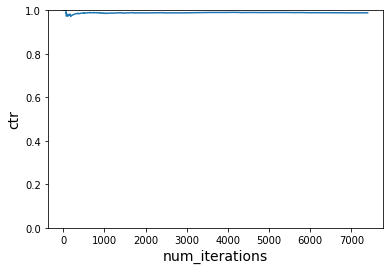

In [116]:
# Instantiate learner in VW
vw = pyvw.vw("--cb_explore 159 --epsilon 0.2 --cb_type ips")

num_iterations = df.shape[0] - 1
ctr = run_simulation(vw, num_iterations, actions, df)

plot_ctr(num_iterations, ctr)